In [1]:
import pandas as pd
import numpy as np
import matrix_modules
import sys
sys.path.append('/home/jovyan/work')
import ExploratoryAnalysis.clustering_modules as cm



In [4]:
user_features.iloc[:, 3:].T

,0,1,2,3,4,5,6,7,8,9,...,248963,248964,248965,248966,248967,248968,248969,248970,248971,248972
finance,0.111111,0.046512,0.000000,0.137931,0.043011,0.000,0.111111,0.166667,0.166667,0.000000,...,0.076923,0.000000,0.033333,0.000000,0.117647,0.000000,0.133333,0.076923,0.111111,0.000
video,0.083333,0.046512,0.000000,0.034483,0.010753,0.000,0.037037,0.083333,0.000000,0.041667,...,0.000000,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.100
tv,0.097222,0.023256,0.111111,0.045977,0.032258,0.100,0.111111,0.000000,0.083333,0.041667,...,0.153846,0.300000,0.100000,0.178571,0.176471,0.000000,0.000000,0.000000,0.000000,0.100
movies,0.013889,0.000000,0.111111,0.022989,0.043011,0.050,0.037037,0.000000,0.083333,0.000000,...,0.000000,0.100000,0.000000,0.059524,0.000000,0.000000,0.133333,0.076923,0.000000,0.000
music,0.013889,0.046512,0.000000,0.022989,0.000000,0.000,0.000000,0.000000,0.083333,0.000000,...,0.076923,0.000000,0.066667,0.023810,0.000000,0.500000,0.000000,0.038462,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
strength,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
newslocalpolitics,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
games-news,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
median_time,0.375000,0.250000,0.375000,0.291667,0.500000,0.375,0.208333,0.375000,0.416667,0.291667,...,0.458333,0.416667,0.708333,0.625000,0.500000,0.458333,0.333333,0.416667,0.333333,0.375


In [6]:
import os
import matrix_modules 
import pandas as pd
import numpy as np
np.random.seed(42)
import sys
sys.path.append('/home/jovyan/work/')
import ExploratoryAnalysis.clustering_modules as cm

"""
This script runs stochastic gradient descent, alternating least squares and factorization machines
with several different parameters to determine their affects on performance.
"""

## Loading data and getting things ready

# Load in the full ratings data with news and users.
print("Loading in data")
full_ratings, news, users = matrix_modules.load_dataset_for_matrix()


# Create a ratings matrix R, and item and user index hash maps for easy subsetting.
als_items = [matrix_modules.create_item_cluster_mat(full_ratings, news, isALS=True, num_users=len(users), num_clusters=len(news['cluster'].unique())),
         matrix_modules.create_user_cluster_mat(full_ratings, news, users, isALS=True, num_user_clusters=len(users['cluster'].unique()))]


# items is now of the form [(R, user_idx, item_idx)]
counter = 0
results = pd.DataFrame()
print("Starting Training Loop")
for i in range(2):

    if i == 0:
        clustering = "item"
        cluster_type = False
    else:
        clustering = "user"
        cluster_type = True

    print("Unpacking info")
    R, item_idx, user_idx = als_items[i]

    # Make the indices into lists and sort them.
    item_idx = {num : sorted(list(users)) for num, users in item_idx.items()}
    user_idx = {user_id : sorted(list(ratings)) for user_id, ratings in user_idx.items()}

    # Create feature matrices for testing.
    user_features = pd.read_csv("../MIND_large/csv/user_features.csv", index_col=0)
    item_features = pd.read_csv("../MIND_large/csv/item_features.csv", index_col=0)
    for j in range(2):
        for k in range(5, 55, 5):

            for lambda_reg in [0.01, 0.10, 1, 2]:
                
                for max_iteration in [10, 100, 1000, 10000]:
                        
                    # Initialize U and V
                    K = k # Here is where we choose the number of latent factors we would like to include in our matrices.
                    I = len(user_idx) # number of users
                    M = len(item_idx) # number of items
                    U = np.random.uniform(0, 1, size=K*I).reshape((K, I))
                    V = np.random.uniform(0, 1, size=K*M).reshape((K, M))
                    # if j == 0:
                    #     if clustering == "item": 
                    #         item_features = item_features.groupby('cluster').agg(sum)
                    #         U = np.concatenate((U, user_features.iloc[:, 3:].T), axis=0)
                    #         V = np.concatenate((V, item_features.iloc[:, 3:].T), axis=0)


                    U, V, track_error, track_update = matrix_modules.alternating_least_squares(U, V, R, user_idx, item_idx, max_iterations=max_iteration, lambda_reg=lambda_reg)
                    param_info = pd.DataFrame(data={"clustering_type": clustering, "alg" : "ALS", "k" : k, "lambda_reg" : lambda_reg, 'RMSE' : [track_error], 'Max Updates' : [track_update]}, index=[counter])
                    counter += 1
                    results = pd.concat([results, param_info], axis=0)
            break


Loading in data
Starting Training Loop
Unpacking info


Starting ALS iterations:   1%|          | 8/1000 [01:01<2:06:14,  7.64s/it]


KeyboardInterrupt: 

In [7]:
results

,clustering_type,alg,k,lambda_reg,RMSE,Max Updates
0,item,ALS,5,0.01,"[1.303687239041997, 1.134792016496023, 1.09508...","[2642176.476173698, 1004851.1854146038, 393105..."
1,item,ALS,5,0.01,"[1.3529698022025411, 1.1695424551258982, 1.113...","[5731861.88477129, 954607.0524404056, 909359.5..."


In [15]:
item_features = pd.read_csv("../MIND_large/csv/item_features.csv", index_col=0)
item_features = cm.item_cluster(item_features, 100)
item_features

Item embeddings found, loading now


,news_id,title,abstract,popularity,autos,entertainment,finance,foodanddrink,games,health,...,watch,weatherfullscreenmaps,weathertopstories,weight-loss,weightloss,wellness,wines,wonder,yearinoffbeatgoodnews,cluster
0,N88753,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117
1,N23144,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,5,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,136
2,N86255,Dispose of unwanted prescription drugs during ...,NaN,8,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49
3,N93187,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,221,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
4,N75236,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",1525,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72018,N99177,Why Kate & Meghan Were on Different Balconies ...,There's no scandal here. It's all about the or...,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117
72019,N97143,See the stars at the 2019 Baby2Baby gala,Stars like Chrissy Teigen and Kate Hudson supp...,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,186
72020,N57903,Tennessee judge holds lawyer's baby as he swea...,Tennessee Court of Appeals Judge Richard Dinki...,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57
72021,N74617,Best Sports Car Deals for October,NaN,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79


In [16]:
item_features.to_csv("../MIND_large/csv/item_features.csv")

In [2]:
# load in the data
ratings, news, users = matrix_modules.load_dataset_for_matrix()

# create the matrix and user 
R, D = matrix_modules.create_item_cluster_mat(ratings, news, num_users=len(users), num_clusters=len(news['cluster'].unique()), isALS=False)

In [3]:
non_zero = R != 0
A_mean = np.mean(R[non_zero])
A_std = np.std(R[non_zero])

# Ensure A_std is not zero to avoid division by zero
epsilon = 1e-8  # A small value
A_standardized = np.where(R!=0, (R - A_mean) / (A_std + epsilon), 0)

A_standardized

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.41665739, -0.41665739,  0.73680101, ...,  0.        ,
        -0.41665739,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.16007181,  0.        , ...,  0.        ,
         0.        , -0.41665739],
       [ 0.        , -0.41665739,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.41665739,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [4]:
A_normalized = np.where(R!=0, (R - R.min()) / (R.max() - R.min()), 0)
A_normalized

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0106383 , 0.0106383 , 0.03191489, ..., 0.        , 0.0106383 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.0212766 , 0.        , ..., 0.        , 0.        ,
        0.0106383 ],
       [0.        , 0.0106383 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0106383 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [7]:

# initialize a dataframe of the matrix to look at data
df = pd.DataFrame(R)
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,1,1,0,0,0,2,0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,3,0,1,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,11,1,0,2,0,0,0,4,0,...,2,3,0,1,0,0,0,0,0,0
4,0,9,2,1,0,0,1,0,0,1,...,1,1,0,2,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
255986,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
255987,0,2,0,0,0,0,0,0,1,0,...,1,0,1,1,0,0,0,0,0,1
255988,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df = pd.DataFrame(A_normalized)
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.000000,0.000000,0.010638,0.010638,0.0,0.000000,0.000000,0.021277,0.000000,...,0.010638,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.010638,0.010638,0.031915,0.000000,0.010638,0.0,0.000000,0.010638,0.010638,0.000000,...,0.010638,0.000000,0.000000,0.010638,0.000000,0.0,0.0,0.0,0.010638,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,0.000000,0.117021,0.010638,0.000000,0.021277,0.0,0.000000,0.000000,0.042553,0.000000,...,0.021277,0.031915,0.000000,0.010638,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.095745,0.021277,0.010638,0.000000,0.0,0.010638,0.000000,0.000000,0.010638,...,0.010638,0.010638,0.000000,0.021277,0.010638,0.0,0.0,0.0,0.010638,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255985,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
255986,0.000000,0.010638,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.010638,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
255987,0.000000,0.021277,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.010638,0.000000,...,0.010638,0.000000,0.010638,0.010638,0.000000,0.0,0.0,0.0,0.000000,0.010638
255988,0.000000,0.010638,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.010638,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [6]:
from tqdm import tqdm

Should consider scaling ratings in matrices to be more normal and on a zero to one scale, this could heavily impact the performance

In [26]:
# initialize U and V
K = 5 # five latent factors tentatively 
I = len(users) # number of users
M = 100 # number of items
np.random.seed(52)
U = np.random.uniform(0, 1, size=K*I).reshape((I, K))
V = np.random.uniform(0, 1, size=K*M).reshape((M, K))

def vectorized_gradient_descent(R,U,V, D, rate=0.00001,max_iterations=10,lam=5, diff_threshold=1e-3):
    """
    Performes vectorized gradient descent to make ratings predictions for the incomplete user-item matrix. Compared to standard gradient descent, 
    vectorized gradient descent further improves upon update formulae by using matrices Gamma and D to operate on U and V for observed ratings 
    instead of iterating over all observed indices.

    Args:
        R (np.ndarray) : The user-item ratings matrix R.
        U (np.ndarray) : The user latent factor matrix U.
        V (np.ndarray) : The item latent factor matrix V.
        D (np.ndarray) : The observed interaction matrix D.
        rate (float) : The learning rate for the gradient descent. Here we need to use small values like 0.00001 due to 
            the numerical instability of our data brought on by clustering.
        max_iterations (int) : The number of iterations to run gradient descent for.
        lam (float) : The regularization parameter which adds a penalty to vectors with large magnitude.
        diff_threshold (float) : The threshold to stop iterating over the data with to avoid computational innefficiency.
    """

    # Create initial Uold and Vold for calculating max updates.
    Uold = np.zeros_like(U)
    Vold = np.zeros_like(V)
    
    # Initialize empty lists to track error and update.
    error_update = []
    track_update = []

    # Perform gradient descent for the number of iterations as specified by max_iterations.
    for t in tqdm(range(1, max_iterations+1), total=max_iterations, desc='Running Optimized Gradient Descent'): # , total=max_iterations, desc="Starting descent"):

        # Create Gamma as the residuals matrix.
        Gamma = R - (U @ V.T)

        # Take the hadamard product of gamma and matrix D to get a matrix of all observed residuals.
        observed_errors = np.multiply(Gamma, D)

        # Update the entire matrix U with vectorized operations.
        U += rate * (observed_errors @ V - lam * U)
        
        # Find Gamma and observed_errors with the updated U.    
        Gamma = R-(U @ V.T)
        observed_errors = np.multiply(Gamma, D)

        # Update the entire matrix V with vectorized operations.
        V += rate * (observed_errors.T @ U - lam * V)

        # Update the update tracking.    
        track_update += [
            max(max_update(U, Uold), max_update(V, Vold))
        ]

        # If our most recent update is lower than our difference threshold, return the Old matrices and information arrays.
        if track_update[-1] < diff_threshold:
            print("Threshold reached, stopping descent")
            return Uold, Vold , error_update, track_update

        # Update Uold and Vold.
        Uold = U.copy() 
        Vold = V.copy()

        # Update the error.
        error_update += [rmse(observed_errors)]
    
    # Return the new U and V and update lists. 
    return U, V , error_update, track_update

U, V, error, updates = vectorized_gradient_descent(R, U, V, D, lam=1, rate=0.00001, max_iterations=100)
U

Running Optimized Gradient Descent: 100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


array([[0.85273994, 0.05665476, 0.24194324, 0.64793738, 0.12865943],
       [0.60427479, 0.03818532, 0.94338069, 0.96376795, 0.50600693],
       [0.62973647, 0.75769151, 0.75799389, 0.41119076, 0.76192699],
       ...,
       [0.10999535, 0.14362204, 0.94358846, 0.21634797, 0.90723196],
       [0.50684018, 0.46581088, 0.66074657, 0.01370569, 0.98440865],
       [0.2418466 , 0.89339888, 0.36010946, 0.77464585, 0.41598634]])

In [29]:
param_info = pd.DataFrame(data={"clustering_type": 'clustering', "alg" : "ALS", "k" : 'k', "lambda_reg" : 'lambda_reg', "umapDim": 'umapDim', 'RMSE' : [error], 'Max Updates' : [updates]}, index=[0])
param_info

,clustering_type,alg,k,lambda_reg,umapDim,RMSE,Max Updates
0,clustering,ALS,k,lambda_reg,umapDim,"[1.8604034732010815, 1.767962142452612, 1.7562...","[1.7976931348623157e+308, 78.00435501548826, 7..."


In [22]:
error_df = pd.DataFrame(error)
error_df

,iter,rmse
0,1,1.860403
1,2,1.767962
2,3,1.756226
3,4,1.751660
4,5,1.749252
...,...,...
95,96,1.713117
96,97,1.712820
97,98,1.712524
98,99,1.712228


In [ ]:
errors = [rmse for rmse in [track_error[i]['rmse'] for i in range(len(track_error))]]
max_updates = [update for update in [track_update[i]['max_update'] for i in range(len(track_update))]]
print(errors)
print(max_updates)
param_info = pd.DataFrame(data={"clustering_type": clustering, "alg" : "ALS", "k" : k, "lambda_reg" : lambda_reg, "umapDim": umapDim, 'RMSE' : [errors], 'Max Updates' : [max_updates]}, index=[counter])
counter += 1
results = pd.concat([results, param_info], axis=0)
print(results)

In [19]:
import matplotlib.pyplot as plt

In [23]:
def plot_error_sgd(error):
    # plots rsme as SGD iterates
    error_df = pd.DataFrame(error, columns=["iter", "rmse"])
    plt.plot(error_df["iter"], error_df["rmse"])
    

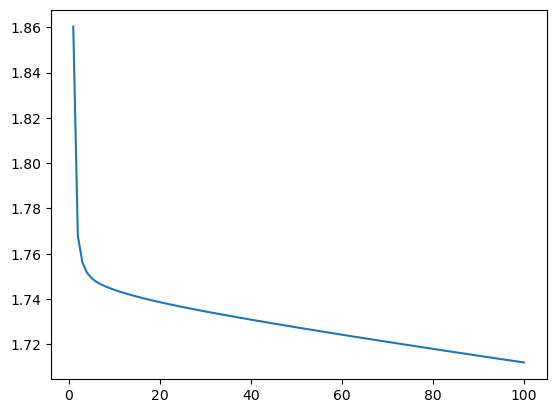

In [24]:
plot_error_sgd(error)

In [17]:
def gradient_descent(R,U,V,rate=0.01,max_iterations=10,lam=5, diff_threshold=1e-3):
    """
    Performes vectorized gradient descent to make ratings predictions for the incomplete user-item matrix. Compared to standard gradient descent, 
    vectorized gradient descent further improves upon update formulae by using matrices Gamma and D to operate on U and V for observed ratings 
    instead of iterating over all observed indices.

    Args:
        R (np.ndarray) : The user-item ratings matrix R.
        U (np.ndarray) : The user latent factor matrix U.
        V (np.ndarray) : The item latent factor matrix V.
        rate (float) : The learning rate for the gradient descent. Here we need to use small values like 0.00001 due to 
            the numerical instability of our data brought on by clustering.
        max_iterations (int) : The number of iterations to run gradient descent for.
        lam (float) : The regularization parameter which adds a penalty to vectors with large magnitude.
        diff_threshold (float) : The threshold to stop iterating over the data with to avoid computational innefficiency.
    """
    # Create initial Uold and Vold for calculating max updates.
    Uold = np.zeros_like(U)
    Vold = np.zeros_like(V)

    # Initialize empty lists to track error and update.
    error_update = []
    track_update = []

    # Perform gradient descent for the number of iterations as specified by max_iterations.
    for t in range(1, max_iterations):
        
        # Iterate over all row and column indices in R where there is not a zero.
        for i, m in tqdm(zip(*np.where(R != 0)), total=len(np.where(R != 0)[0]), desc="Iterating Over R", leave=True):

            # Calculate the penalty terms.
            u_penalty = 2 * rate * lam * U[i]
            v_penalty = 2 * rate * lam * V[m]

            # Calculate the error and then update U[i]
            error = R[i, m] - (V[m] * U[i])
            U[i] = U[i] + ((2 * rate * error) * V[m]) - u_penalty

            # Calculate the error again with updated U[i] and then update V[m]
            error = R[i, m] - (V[m] * U[i])
            V[m] = V[m] + ((2 * rate * error) * U[i]) - v_penalty

        # Update the update tracking.    
        track_update += [{
            'iteration':t, 
            'max update':max(max_update(U, Uold), max_update(V, Vold))
        }]

        # Update Uold and Vold.
        Uold = U.copy()
        Vold = V.copy()

        # If our most recent update is lower than our difference threshold, return the Old matrices and information arrays.
        if track_update[-1] < diff_threshold:
            print("Threshold reached, stopping descent")
            return Uold, Vold , error_update, track_update
        
        # compute error after one sweep of updates
        error_update += [(t, rmse(R-(U @ V.T)))]
        
    return U, V , error_update, track_update

# U, V = SGD(R, U, V)

U, V, error, updates = gradient_descent(R, U, V, max_iterations=5)
U

Iterating Over R:   7%|▋         | 248395/3808726 [00:03<00:51, 69660.27it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
(1, rmse(R-(U @ V.T)))

In [ ]:
R.shape

In [ ]:
def plot_iter(x, rmse_test, hyper_param, burn_in):
  fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(15, 8))

  axes[0, 0].plot(x, rmse_test[burn_in:], label='test rmse', color="r")
  axes[0, 0].legend()
  axes[0, 1].plot(x, hyper_param[burn_in:,0], label='alpha', color="b")
  axes[0, 1].legend()
  axes[1, 0].plot(x, hyper_param[burn_in:,1], label='lambda_w', color="g")
  axes[1, 0].legend()
  axes[1, 1].plot(x, hyper_param[burn_in:,3], label='mu_w', color="g")
  axes[1, 1].legend()

In [ ]:
pd.DataFrame(U @ V.T)